In [1]:
from pathlib import Path
import geopandas as gpd
import folium 
from shapely.geometry import LineString, Polygon, box, shape
import rasterio
import os
import matplotlib.pyplot as plt
import pandas as pd
import rasterio.features

In [2]:
root_dir = Path(r"P:\bovenregionale-stresstest-hwn\Scripts\RA2CE_Model\data\Test_Run")

static_path = root_dir.joinpath("static") #within your root directory there should be a 'static' folder
network_path = static_path.joinpath("network") #within the static folder there should be a 'network' folder
hazard_path = static_path.joinpath("hazard") #within the static folder there should be a 'hazard' folder
output_path = static_path.joinpath("output_graph")
assert root_dir.exists(), "root_dir not found."

In [3]:
# hazard_map = hazard_path.joinpath("hazard.tif")  # Put the name of your hazard map here

In [4]:
hazard_graph = gpd.read_file(output_path.joinpath("base_network_hazard.gpkg"), driver='GPKG')

Finding thresholds that are suitable

    fraction_threshold  depth_threshold  flooded_count  isolated_count  \
0                  0.5              0.1            308              53   
1                  0.5              0.2            250              44   
2                  0.5              0.4            160              30   
3                  0.5              0.3            214              42   
4                  0.4              0.1            347              70   
5                  0.5              0.5            122              24   
6                  0.4              0.2            278              59   
7                  0.3              0.1            375              81   
8                  0.3              0.2            295              66   
9                  0.2              0.1            406              92   
10                 0.1              0.1            447             104   
11                 0.4              0.4            173              40   
12                 0.4              0.

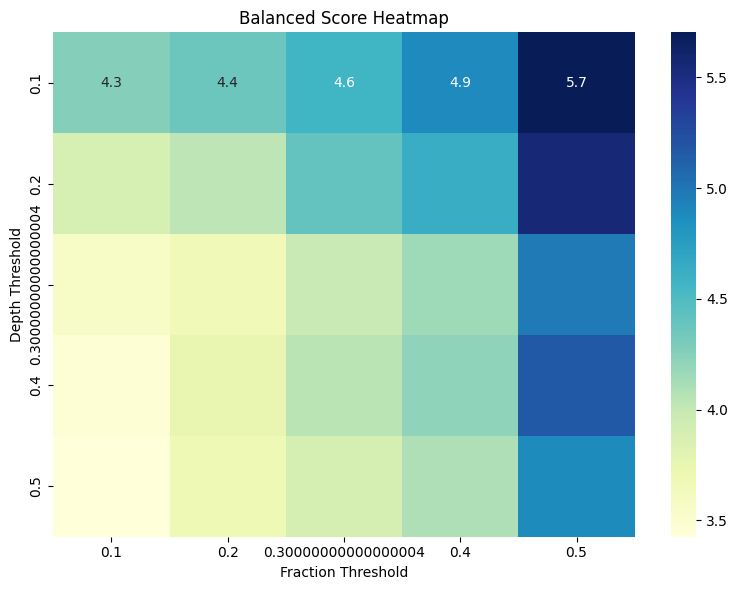

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure seaborn is installed

# --- Parameters ---
zone_column = 'zone'  # Optional: column name for spatial aggregation
fraction_range = np.linspace(0.1, 0.5, 5)
depth_range = np.linspace(0.1, 0.5, 5)

# --- Step 1: Load your data ---
gdf_original = hazard_graph.copy()

# --- Step 2: Sensitivity analysis ---
results = []

for f_thresh in fraction_range:
    for d_thresh in depth_range:
        gdf = gdf_original.copy()
        gdf['is_flooded'] = (gdf['EV1_fr'] > f_thresh) & (gdf['EV1_me'] > d_thresh)

        # Identify isolated flooded segments
        def is_isolated(index, flooded_series):
            if not flooded_series.iloc[index]:
                return False
            neighbors = []
            if index > 0:
                neighbors.append(flooded_series.iloc[index - 1])
            if index < len(flooded_series) - 1:
                neighbors.append(flooded_series.iloc[index + 1])
            return not any(neighbors)

        gdf['is_isolated'] = [is_isolated(i, gdf['is_flooded']) for i in range(len(gdf))]

        flooded_count = gdf['is_flooded'].sum()
        isolated_count = gdf['is_isolated'].sum()
        score = flooded_count / (1 + isolated_count)

        results.append({
            'fraction_threshold': f_thresh,
            'depth_threshold': d_thresh,
            'flooded_count': flooded_count,
            'isolated_count': isolated_count,
            'score': score
        })

# --- Step 3: Create DataFrame and classify exposure ---
results_df = pd.DataFrame(results)

# Normalize score for classification
results_df['score_norm'] = (results_df['score'] - results_df['score'].min()) / (results_df['score'].max() - results_df['score'].min())

# Classify exposure levels
def classify_exposure(score):
    if score >= 0.8:
        return 'High'
    elif score >= 0.4:
        return 'Moderate'
    else:
        return 'Low'

results_df['exposure_class'] = results_df['score_norm'].apply(classify_exposure)

# --- Step 4: Display ranked results ---
results_df = results_df.sort_values(by='score', ascending=False).reset_index(drop=True)
print(results_df)

# --- Step 5: Optional heatmap visualization ---
pivot = results_df.pivot(index='depth_threshold', columns='fraction_threshold', values='score')
plt.figure(figsize=(8, 6))
plt.title('Balanced Score Heatmap')
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.xlabel('Fraction Threshold')
plt.ylabel('Depth Threshold')
plt.tight_layout()
plt.show()


In [6]:
gdf.to_file(output_path.joinpath("flooded_segments.gpkg"), driver='GPKG')